In [494]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, plot_confusion_matrix, plot_roc_curve

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import folium 

## Important

In order to use run this data you must download the data sets from the following 3 links and store them in the same folder as your notebook
1. https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if
2. https://data.cityofchicago.org/Transportation/Traffic-Crashes-Vehicles/68nd-jvt3
3. https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d

In [299]:
#importing datasets
df = pd.read_csv('../Traffic_Crashes_-_Crashes.csv')
df_people = pd.read_csv('../Traffic_Crashes_-_People.csv')
df_vehicles = pd.read_csv('../Traffic_Crashes_-_Vehicles.csv')
df.head()

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (12,13,20,21,22,23,24,25,26,27,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (19,21,40,41,42,44,48,49,50,53,55,58,59,61,71) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,CRASH_RECORD_ID,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,JC343143,NaN,07/10/2019 05:56:00 PM,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,...,0.0,0.0,3.0,0.0,17,4,7,41.919664,-87.773288,POINT (-87.773287883007 41.919663832993)
1,009e9e67203442370272e1a13d6ee51a4155dac65e583d...,JA329216,NaN,06/30/2017 04:00:00 PM,35,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,...,0.0,0.0,3.0,0.0,16,6,6,41.741804,-87.740954,POINT (-87.740953581987 41.741803598989)
2,ee9283eff3a55ac50ee58f3d9528ce1d689b1c4180b4c4...,JD292400,NaN,07/10/2020 10:25:00 AM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,...,0.0,0.0,3.0,0.0,10,6,7,41.773456,-87.585022,POINT (-87.585022352022 41.773455972008)
3,f8960f698e870ebdc60b521b2a141a5395556bc3704191...,JD293602,NaN,07/11/2020 01:00:00 AM,30,NO CONTROLS,NO CONTROLS,CLEAR,DARKNESS,PARKED MOTOR VEHICLE,...,0.0,0.0,3.0,0.0,1,7,7,41.802119,-87.622115,POINT (-87.622114914961 41.802118543011)
4,8eaa2678d1a127804ee9b8c35ddf7d63d913c14eda61d6...,JD290451,NaN,07/08/2020 02:00:00 PM,20,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,...,0.0,0.0,1.0,0.0,14,4,7,NaN,NaN,NaN


In [370]:
#Merging Datasets on the Crash_Record_ID Column
df_merge = pd.merge(df, df_vehicles, on='CRASH_RECORD_ID').reset_index()
df_merge_2 = pd.merge(df_merge, df_people, on='CRASH_RECORD_ID').reset_index()
#dropping dupllicates(basically only having one instance of the crashID on there)
df_dropped= df_merge_2.drop_duplicates(subset=['CRASH_RECORD_ID'], keep='first')
#Taking only necessary columns
columns = ['CRASH_RECORD_ID', 'RD_NO_x', 'CRASH_DATE_x', 'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 
           'DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 
           'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'CRASH_TYPE', 'INTERSECTION_RELATED_I', 
           'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 
           'STREET_NO', 'STREET_DIRECTION', 'STREET_NAME',  'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 
           'WORKERS_PRESENT_I', 'NUM_UNITS', 'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL', 
           'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 
           'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 
           'LATITUDE', 'LONGITUDE', 'LOCATION', 'RD_NO_y', 'UNIT_NO', 'UNIT_TYPE', 'NUM_PASSENGERS', 
           'VEHICLE_ID_x', 'CMRC_VEH_I', 'MAKE', 'MODEL', 'VEHICLE_YEAR', 'VEHICLE_DEFECT', 'VEHICLE_TYPE', 
           'TRAVEL_DIRECTION', 'MANEUVER', 'OCCUPANT_CNT', 'EXCEED_SPEED_LIMIT_I', 'FIRST_CONTACT_POINT', 
           'PERSON_TYPE', 'CITY', 'STATE', 'ZIPCODE', 'SEX', 'AGE',  'AIRBAG_DEPLOYED', 'EJECTION', 
           'INJURY_CLASSIFICATION', 'DRIVER_VISION','PHYSICAL_CONDITION', 'PEDPEDAL_ACTION', 
           'PEDPEDAL_VISIBILITY', 'PEDPEDAL_LOCATION', 'BAC_RESULT', 'BAC_RESULT VALUE', 'CELL_PHONE_USE']
df_comb = df_dropped[columns]

In [371]:
#Taking the Year from the date column
df_comb['date'] = pd.to_datetime(df_comb['CRASH_DATE_x'])
df_comb['Crash_year'] = df_comb['date'].apply(lambda date: date.year)
#only accidents with the driver
df_driver = df_comb[df_comb['PERSON_TYPE']=='DRIVER']
#necessary columns
new_columns = ['CRASH_RECORD_ID', 'CRASH_DATE_x', 'POSTED_SPEED_LIMIT',
       'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION',
       'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE',
       'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'CRASH_TYPE',
       'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE','NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT','CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LATITUDE', 'LONGITUDE', 'MAKE', 'MODEL',
       'VEHICLE_YEAR', 'VEHICLE_DEFECT', 'VEHICLE_TYPE',
       'MANEUVER', 'OCCUPANT_CNT', 
       'FIRST_CONTACT_POINT', 'PERSON_TYPE','SEX',
       'AGE', 'AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION','DRIVER_VISION',
       'PHYSICAL_CONDITION', 'Crash_year']

<ipython-input-371-6efbe8c7bb70>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comb['date'] = pd.to_datetime(df_comb['CRASH_DATE_x'])
<ipython-input-371-6efbe8c7bb70>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comb['Crash_year'] = df_comb['date'].apply(lambda date: date.year)


In [ ]:
['AGE', 'CRASH_HOUR','CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'POSTED_SPEED_LIMIT',
           'WEATHER_CONDITION','LIGHTING_CONDITION','TRAFFIC_CONTROL_DEVICE',
           'PHYSICAL_CONDITION','VEHICLE_DEFECT','INJURIES_FATAL']

In [372]:
#Dataframe with the new columns
df_driver = df_driver[new_columns]
#check for nulls
# pd.isnull(df_driver).sum()

In [373]:
#dropping missing values
df_driver.dropna(axis=0, subset=['LATITUDE'], inplace =True)
df_driver.dropna(axis=0, subset=['LONGITUDE'], inplace =True)
df_driver.dropna(axis=0, subset=['MODEL'], inplace =True)
df_driver.dropna(axis=0, subset=['MAKE'], inplace =True)
df_driver.dropna(axis=0, subset=['FIRST_CONTACT_POINT'], inplace =True)

In [374]:
# Handling nulls for AGE, SEX, and VEHICLE_YEAR
df_driver = df_driver[(df_driver.VEHICLE_YEAR>=1970) & (df_driver.VEHICLE_YEAR <=2021)]
df_driver.AGE.replace({np.NAN: df_driver.AGE.median()},inplace=True)
df_driver.SEX.replace({np.NAN : 'X'},inplace=True)
# Reassigning values for INJURIES FATAL
df_driver.INJURIES_FATAL.replace({0.0:0, 1.0:1, 2.0:1, 3.0:1, 4.0:1}, inplace=True)
df_driver.shape

(394153, 45)

In [ ]:
df_driver = df_driver[(df_driver.WEATHER_CONDITION != 'UNKNOWN')&(df_driver.WEATHER_CONDITION != 'OTHER')]
df_driver = df_driver[df_driver.LIGHTING_CONDITION != 'UNKNOWN']
df_driver = df_driver[(df_driver.TRAFFIC_CONTROL_DEVICE != 'UNKNOWN')&(df_driver.TRAFFIC_CONTROL_DEVICE != 'OTHER')]
df_driver = df_driver[df_driver.PHYSICAL_CONDITION != 'UNKNOWN'df_driver.PHYSICAL_CONDITION != 'OTHER')]

In [ ]:
# df = df[df.line_race != 0]
# WEATHER_CONDITION: UNKNOWN, OTHER
# LIGHTING_CONDITION: UNKNOWN
# TRAFFIC_CONTROL_DEVICE: UNKNOWN, OTHER
# PHYSICAL_CONDITION: UNKNOWN, OTHER

In [375]:
# dropping columns we do not need
columns_to_drop = ['CRASH_RECORD_ID','CRASH_DATE_x','INJURIES_TOTAL','INJURIES_INCAPACITATING',
                   'INJURIES_NON_INCAPACITATING','INJURIES_REPORTED_NOT_EVIDENT','MAKE','MOST_SEVERE_INJURY',
                   'MODEL','VEHICLE_YEAR','OCCUPANT_CNT','PERSON_TYPE',
                   'INJURY_CLASSIFICATION','CRASH_TYPE','LONGITUDE','LATITUDE','Crash_year']

df_driver = df_driver.drop(columns_to_drop,axis=1)

In [376]:
# Decided Features to use
features = ['AGE', 'CRASH_HOUR','CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'POSTED_SPEED_LIMIT',
           'WEATHER_CONDITION','LIGHTING_CONDITION','TRAFFIC_CONTROL_DEVICE',
           'PHYSICAL_CONDITION','VEHICLE_DEFECT','INJURIES_FATAL']
test_df = df_driver[features]

In [377]:
# df_driver.hist(figsize=(20,20), bins='auto');

In [378]:
df_driver.INJURIES_FATAL.value_counts()

0.0    393727
1.0       426
Name: INJURIES_FATAL, dtype: int64

# Data Preperation

In [379]:
# test_df = df_driver.copy()
# test_df = test_df[['AGE', 'CRASH_HOUR', 'POSTED_SPEED_LIMIT', 'INJURIES_FATAL']]
# # make columns equal legnth 
# test_df = test_df[test_df['AGE'].notna()]

In [380]:
# data = test_df[['AGE', 'CRASH_HOUR', 'POSTED_SPEED_LIMIT']].astype('int16')
# target = test_df.INJURIES_FATAL.values.astype('int16')

In [573]:
test_df.columns

Index(['AGE', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'POSTED_SPEED_LIMIT', 'WEATHER_CONDITION', 'LIGHTING_CONDITION',
       'TRAFFIC_CONTROL_DEVICE', 'PHYSICAL_CONDITION', 'VEHICLE_DEFECT',
       'INJURIES_FATAL'],
      dtype='object')

In [586]:
test_df.VEHICLE_DEFECT.value_counts()

NONE                212501
UNKNOWN             175307
BRAKES                2573
OTHER                 2239
TIRES                  455
STEERING               445
WHEELS                 226
SUSPENSION             162
ENGINE/MOTOR            89
FUEL SYSTEM             42
LIGHTS                  41
WINDOWS                 26
CARGO                   15
SIGNALS                 11
RESTRAINT SYSTEM        10
EXHAUST                  7
TRAILER COUPLING         4
Name: VEHICLE_DEFECT, dtype: int64

In [394]:
X = test_df.drop('INJURIES_FATAL',axis=1)
y = test_df.INJURIES_FATAL

# train-test split

In [395]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [396]:
X_train

,AGE,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,POSTED_SPEED_LIMIT,WEATHER_CONDITION,LIGHTING_CONDITION,TRAFFIC_CONTROL_DEVICE,PHYSICAL_CONDITION,VEHICLE_DEFECT
1634697,36.0,13,5,10,30,CLEAR,DAYLIGHT,NO CONTROLS,UNKNOWN,UNKNOWN
657774,43.0,15,6,3,30,CLOUDY/OVERCAST,DAYLIGHT,NO CONTROLS,UNKNOWN,UNKNOWN
1116500,37.0,17,5,8,25,CLEAR,DAYLIGHT,TRAFFIC SIGNAL,NORMAL,NONE
2366276,37.0,11,1,1,30,CLEAR,DAYLIGHT,TRAFFIC SIGNAL,NORMAL,NONE
2373724,45.0,16,5,10,30,CLEAR,DAYLIGHT,TRAFFIC SIGNAL,NORMAL,NONE
...,...,...,...,...,...,...,...,...,...,...
1774562,31.0,13,3,7,30,CLEAR,DAYLIGHT,NO CONTROLS,NORMAL,NONE
2467929,21.0,16,7,11,30,CLEAR,"DARKNESS, LIGHTED ROAD",STOP SIGN/FLASHER,NORMAL,NONE
947912,36.0,15,7,12,30,CLEAR,DAYLIGHT,NO CONTROLS,NORMAL,NONE
1045726,54.0,10,1,11,30,CLEAR,DAYLIGHT,NO CONTROLS,NORMAL,NONE


### One Hot Encoding 

In [397]:
#Ohe-ing Train set
X_train_cat = X_train.select_dtypes('object')

ohe = OneHotEncoder(
    drop='first',
    sparse=False)

dums_train = ohe.fit_transform(X_train_cat)
dums_train_df = pd.DataFrame(dums_train,
                       columns=ohe.get_feature_names(),
                       index=X_train_cat.index)

nums_train_df = X_train.select_dtypes(['int64','float64'])

X_train_clean = pd.concat([nums_train_df, dums_train_df], axis=1)

In [398]:
#Ohe-ing Test set
X_test_cat = X_test.select_dtypes('object')

dums_test = ohe.transform(X_test_cat)
dums_test_df = pd.DataFrame(dums_test,
                       columns=ohe.get_feature_names(),
                       index=X_test_cat.index)

nums_test_df = X_test.select_dtypes(['int64','float64'])

X_test_clean = pd.concat([nums_test_df, dums_test_df], axis=1)

### Smote

In [399]:
# X_train_clean.columns
smote = SMOTE(sampling_strategy='auto',random_state=42)
X_train_resampled, y_train_resampled = smote.fit_sample(X_train_clean, y_train) 

# Decision Tree

In [400]:
tree = DecisionTreeClassifier()

In [401]:
tree_grid = {'max_leaf_nodes': [2,3,4,5], 
             'min_samples_split': [2, 3, 4],
             'max_depth': [3,4,5, 6, 7, 8, 9],
            }


In [402]:
tree_grid_search = GridSearchCV(tree, tree_grid, cv=5)

In [405]:
tree_grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9],
                         'max_leaf_nodes': [2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4]})

In [406]:
tree_grid_search.best_params_

{'max_depth': 3, 'max_leaf_nodes': 5, 'min_samples_split': 2}

In [407]:
tree_grid_search.best_score_

0.8864146664070258

In [408]:
tree_grid_search.best_estimator_.score(X_test_clean, y_test)

0.897198063710815

In [409]:
best_tree = tree_grid_search.best_estimator_

In [468]:
tree_test_preds = best_tree.predict(X_test_clean)

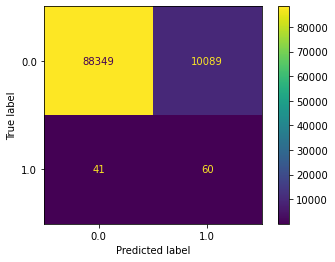

In [569]:
plot_confusion_matrix(best_tree, X_test_clean, y_test, values_format = '');

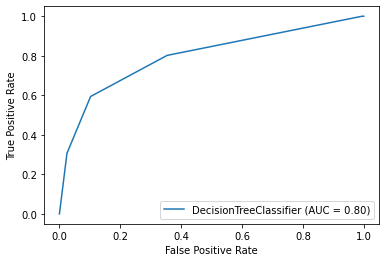

In [523]:
plot_roc_curve(best_tree, X_test_clean, y_test);

In [467]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

In [469]:
print_metrics(y_test, tree_test_preds)

Precision Score: 0.005911912503694945
Recall Score: 0.594059405940594
Accuracy Score: 0.897198063710815
F1 Score: 0.011707317073170732


In [530]:
tree_features = list(zip(best_tree.feature_importances_, X_train_resampled.columns.values))
tree_features = [x for x in tree_features if x[0] > 0]
tree_features = sorted(tree_features, key=lambda x: x[0], reverse=True)
tree_features_values = [x[0] for x in tree_features]
tree_features_names = [x[1] for x in tree_features]

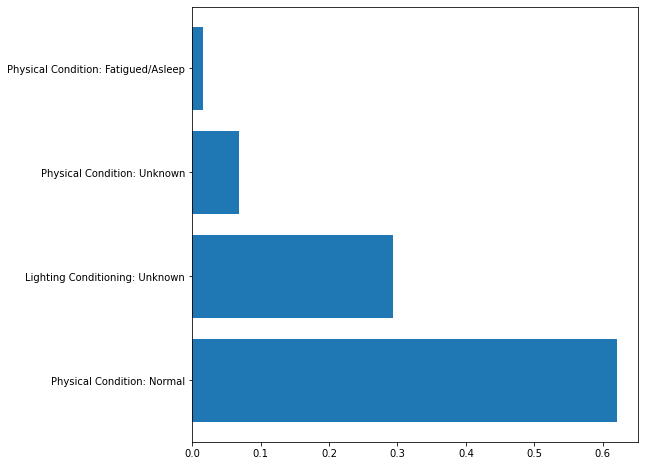

In [546]:
plt.figure(figsize=(8,8))
tree_labels = ['Physical Condition: Normal', 'Lighting Conditioning: Unknown',
            'Physical Condition: Unknown', 'Physical Condition: Fatigued/Asleep']
plt.barh(tree_features_names, tree_features_values, align='center', tick_label=tree_labels)
plt.ylabel('');

In [412]:
tree_cv_df = pd.DataFrame(tree_grid_search.cv_results_)
tree_cv_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.740934,0.033919,0.018584,0.002781,3,2,2,"{'max_depth': 3, 'max_leaf_nodes': 2, 'min_sam...",0.802254,0.799858,0.800078,0.800127,0.799551,0.800374,0.000962,64
1,0.713232,0.005466,0.017144,0.000153,3,2,3,"{'max_depth': 3, 'max_leaf_nodes': 2, 'min_sam...",0.802254,0.799858,0.800078,0.800127,0.799551,0.800374,0.000962,64
2,0.712216,0.004985,0.017172,0.000117,3,2,4,"{'max_depth': 3, 'max_leaf_nodes': 2, 'min_sam...",0.802254,0.799858,0.800078,0.800127,0.799551,0.800374,0.000962,64
3,0.934816,0.004229,0.017204,0.000326,3,3,2,"{'max_depth': 3, 'max_leaf_nodes': 3, 'min_sam...",0.847277,0.847802,0.846473,0.849105,0.848893,0.847910,0.000987,43
4,0.929203,0.002677,0.017724,0.000746,3,3,3,"{'max_depth': 3, 'max_leaf_nodes': 3, 'min_sam...",0.847277,0.847802,0.846473,0.849105,0.848893,0.847910,0.000987,43


# Random Forest

In [413]:
forest = RandomForestClassifier()

In [419]:
# The number of features to consider when looking for the best split
max_features = ['sqrt', 'log2']

# function to measure the quality of a split
# criteria = ['gini', 'entropy']

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
forrest_grid = {'max_features': max_features,
                'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
              }

In [420]:
forrest_grid_search = GridSearchCV(estimator=forest, param_grid=forrest_grid, cv=5)

In [421]:
forrest_grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [422]:
forrest_grid_search.best_params_

{'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}

In [423]:
forrest_grid_search.best_score_

0.9991652262853918

In [424]:
forrest_grid_search.best_estimator_.score(X_test_clean, y_test)

0.9984676118085225

In [426]:
best_forest = forrest_grid_search.best_estimator_

In [465]:
forrest_test_preds = forrest_grid_search.predict(X_test_clean)

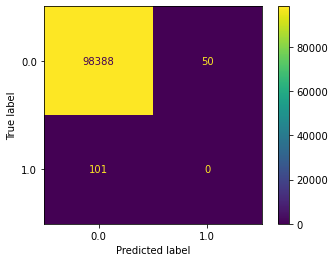

In [570]:
plot_confusion_matrix(best_forest, X_test_clean, y_test, values_format='');

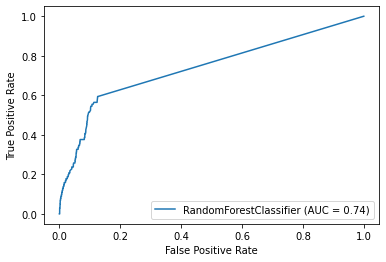

In [496]:
plot_roc_curve(best_forest, X_test_clean, y_test);

In [466]:
print_metrics(y_test, forrest_test_preds)

Precision Score: 0.0
Recall Score: 0.0
Accuracy Score: 0.9984676118085225
F1 Score: 0.0


In [561]:
np.set_printoptions(formatter={'float_kind':'{:2f}'.format})
forrest_features = list(zip(best_forest.feature_importances_, X_train_resampled.columns.values))
forrest_features = [x for x in forrest_features if x[0] > .05]
forrest_features = sorted(forrest_features, key=lambda x: x[0], reverse=True)
forrest_features_values = [x[0] for x in forrest_features]
forrest_features_names = [x[1] for x in forrest_features]

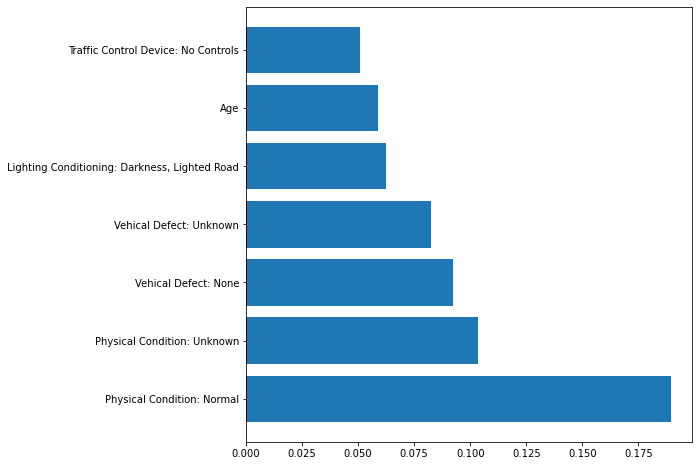

In [571]:
plt.figure(figsize=(8,8))
forrest_labels = ['Physical Condition: Normal', 'Physical Condition: Unknown',
            'Vehical Defect: None', 'Vehical Defect: Unknown', 'Lighting Conditioning: Darkness, Lighted Road',
                 'Age', 'Traffic Control Device: No Controls']
plt.barh(forrest_features_names, forrest_features_values, align='center', tick_label=forrest_labels);

In [429]:
forest_cv_df = pd.DataFrame(forrest_grid_search.cv_results_)
forest_cv_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,31.361604,0.912728,0.951896,0.037219,sqrt,1,2,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.997003,0.999661,0.999763,0.999636,0.999721,0.999157,0.001078,5
1,31.169856,0.724094,0.949724,0.033277,sqrt,1,5,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.996978,0.999712,0.999729,0.999636,0.999704,0.999152,0.001088,6
2,31.725516,0.978695,0.948719,0.033672,sqrt,1,10,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.997020,0.999704,0.999763,0.999611,0.999729,0.999165,0.001074,1
3,30.976589,0.609875,0.913519,0.032566,sqrt,2,2,"{'max_features': 'sqrt', 'min_samples_leaf': 2...",0.996994,0.999670,0.999678,0.999568,0.999712,0.999125,0.001066,7
4,31.082010,0.600566,0.912185,0.033520,sqrt,2,5,"{'max_features': 'sqrt', 'min_samples_leaf': 2...",0.996986,0.999670,0.999611,0.999526,0.999721,0.999103,0.001060,9


# Kne

In [277]:
# One-hot encode the categorical columns
# one_hot_df = pd.get_dummies(test_df)
# one_hot_df.head()

,AGE,CRASH_HOUR,POSTED_SPEED_LIMIT,INJURIES_FATAL
0,31.0,17,35,0.0
6,20.0,16,35,0.0
12,50.0,10,30,0.0
29,45.0,22,30,0.0
33,27.0,14,35,0.0


In [279]:
# labels = one_hot_df['INJURIES_FATAL']
# data = one_hot_df.drop(['INJURIES_FATAL'], axis=1)

In [280]:
# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.5, random_state=42)

In [281]:
# Instantiate StandardScaler
# scaler = StandardScaler()

# Transform the training and test sets
# scaled_data_train = scaler.fit_transform(X_train)
# scaled_data_test = scaler.transform(X_test)

In [433]:
# knn = KNeighborsClassifier()

In [434]:
# create params_grid for KNeighborsClassifier  
# knn_grid = {'n_neighbors': [3, 5, 7, 9, 11, 21],
#               'weights': ['uniform', 'distance'],
#               'metric': ['euclidean', 'manhattan']}

# create grid search 
# knn_grid = GridSearchCV(knn, knn_grid, cv=5)

In [436]:
# fit x_train and y_train to grid 
# knn_grid.fit(X_train_resampled, y_train_resampled)

In [437]:
# observe combination of best params 
# knn_grid.best_params_

In [438]:
# knn_cv_df = pd.DataFrame(knn_grid.cv_results_)
# knn_cv_df.head()

In [439]:
# knn_grid.best_estimator_.score(X_test_clean, y_test)

# map

In [479]:
map_df = df[['LATITUDE', 'LONGITUDE']].loc[df.INJURIES_FATAL > 0]
map_df.dropna(inplace=True)

In [488]:

map_center = [map_df.LATITUDE.mean(), map_df.LONGITUDE.mean()]

crash_map = folium.Map(location=map_center, zoom_start=10, control_scale=True)

for index, location_info in map_df.iterrows():
    folium.Marker([location_info["LATITUDE"], location_info["LONGITUDE"]]).add_to(crash_map)

In [564]:
# crash_map